In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
import os

In [2]:
dataset_path='D:\observations-master\experiements\data'

In [3]:
#load images
withmask=[]
path_withmask='D:\observations-master\experiements\data\with_mask'
withmask=os.listdir(path_withmask)
print(len(withmask))

706


In [4]:
#load images
withoutmask=[]
path_withoutmask='D:\observations-master\experiements\data\without_mask'
withoutmask=os.listdir(path_withoutmask)
print(len(withoutmask))

744


In [5]:
LEN=len(withmask)+len(withoutmask)
BATCH_SIZE=32
EPOCHS=20
SIZE=100
train_image_datagenerator=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    fill_mode='nearest')

In [6]:
train_image_datagen=train_image_datagenerator.flow_from_directory(
                        batch_size=BATCH_SIZE,
                        directory=dataset_path,
                        shuffle=True,
                        target_size=(SIZE,SIZE),
                        class_mode='binary')

Found 1448 images belonging to 2 classes.


In [7]:
sample,_=next(train_image_datagen)

In [8]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

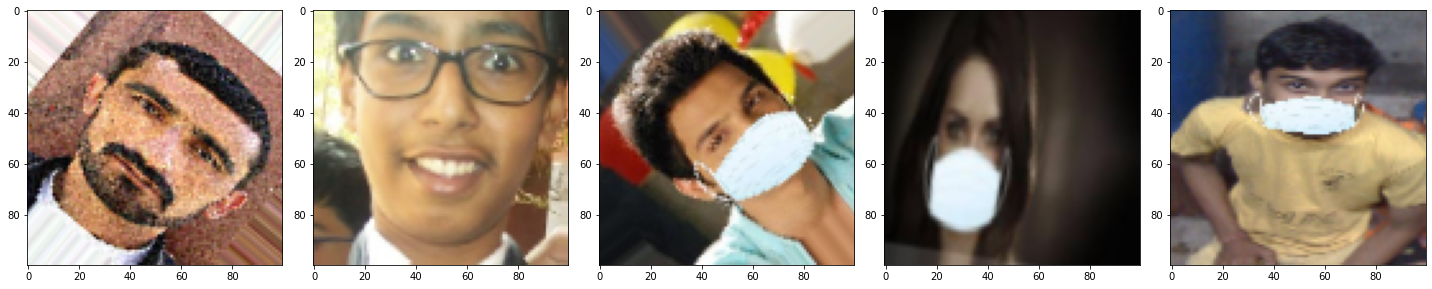

In [9]:
plotImages(sample[:5])

In [10]:
#build model
model=tf.keras.Sequential([ 
                tf.keras.layers.Conv2D(200,(3,3),input_shape=[100,100,3]),
                tf.keras.layers.MaxPooling2D((2,2)),
                tf.keras.layers.Conv2D(100,(3,3),activation='relu'),
                tf.keras.layers.MaxPooling2D((2,2)),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dropout(0.5),
                tf.keras.layers.Dense(64,activation='relu'),
                tf.keras.layers.Dense(2)])

In [11]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits='true'),
             optimizer='Adam',metrics=[['accuracy']])

In [12]:
checkpoint_path = "D:\AI_projects\cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [13]:
history=model.fit_generator(train_image_datagen,epochs=EPOCHS,
                            callbacks=[cp_callback],
                           steps_per_epoch=int(np.ceil(LEN/float(BATCH_SIZE))))

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 46 steps
Epoch 1/20


D:\Anaconda\envs\tensorflow\lib\site-packages\PIL\Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


45/46 [============================>.] - ETA: 0s - loss: 0.6691 - accuracy: 0.6568
Epoch 00001: saving model to D:\AI_projects\cp.ckpt
46/46 [==============================] - 38s 833ms/step - loss: 0.6653 - accuracy: 0.6588
Epoch 2/20
45/46 [============================>.] - ETA: 0s - loss: 0.2422 - accuracy: 0.9145
Epoch 00002: saving model to D:\AI_projects\cp.ckpt
46/46 [==============================] - 10s 218ms/step - loss: 0.2386 - accuracy: 0.9164
Epoch 3/20
45/46 [============================>.] - ETA: 0s - loss: 0.1612 - accuracy: 0.9421
Epoch 00003: saving model to D:\AI_projects\cp.ckpt
46/46 [==============================] - 10s 218ms/step - loss: 0.1598 - accuracy: 0.9434
Epoch 4/20
45/46 [============================>.] - ETA: 0s - loss: 0.1456 - accuracy: 0.9470
Epoch 00004: saving model to D:\AI_projects\cp.ckpt
46/46 [==============================] - 11s 235ms/step - loss: 0.1437 - accuracy: 0.9482
Epoch 5/20
45/46 [============================>.] - ETA: 0s - loss:

In [14]:
model.save('D:\AI_projects\mask_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: D:\AI_projects\mask_model\assets


In [15]:
face_classifier=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')


In [16]:
source=cv2.VideoCapture(0) #define cam as input
labels_dict={0:'NO MASK',1:' MASK'}
color_dict={1:(0,255,0),0:(0,0,255)}
while(True):
    ret,img=source.read() #read input
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) #trn image to gray for model
    faces=face_classifier.detectMultiScale(gray,1.3,5)#call cv2 face detector
    
    for (x,y,w,h) in faces: # iterate over the faces
        face_part=img[y:y+h,x:x+w]
        resized=cv2.resize(face_part,(100,100))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,100,100,3))
        result=model.predict(reshaped)
        label=np.argmax(result,axis=1)[0]
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(img, labels_dict[label], (x, y-  10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
 
    
    cv2.imshow('LIVE',img) #display result
    key=cv2.waitKey(1)
    
    if(key==27): #press Esc to exit
        break
 
cv2.destroyAllWindows()
source.release()

KeyboardInterrupt: 